In [1]:
import os
import torch
from torch_geometric.datasets import QM9
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd

In [8]:
dataset_path = '.'
dataset = QM9(dataset_path)
print(dataset)
print("Number of molecules:", len(dataset))
print("Available labels:", dataset.data.y.shape, " (19 per molecule)")

Extracting ./raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [01:52<00:00, 1187.87it/s]
Done!


QM9(130831)
Number of molecules: 130831
Available labels: torch.Size([130831, 19])  (19 per molecule)


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [9]:
mol = dataset[0]
print(mol)

# There are 19 target properties, documented in QM9 paper
print("Targets for molecule 0:", mol.y)

# Example: Dipole moment µ is target index 0
dipole_moment = mol.y[0, 0].item()
print("Dipole moment:", dipole_moment)


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])
Targets for molecule 0: tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])
Dipole moment: 0.0


In [10]:
# Load SMILES list
smiles_list = dataset.smiles

# Convert first few molecules to RDKit Mol
rdkit_mols = [Chem.MolFromSmiles(s) for s in smiles_list[:5]]
rdkit_mols


In [11]:
def mol_to_fp(mol, radius=2, n_bits=2048):
    """Convert RDKit Mol to Morgan fingerprint vector."""
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,))
    Chem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Example on first 3 molecules
fps = [mol_to_fp(m) for m in rdkit_mols]
print("Shape of one fingerprint:", fps[0].shape)


Shape of one fingerprint: (2048,)


In [12]:
from tqdm import tqdm

# Parameters
radius = 2
n_bits = 2048

# Preallocate
num_mols = len(dataset)
X = np.zeros((num_mols, n_bits), dtype=np.float32)
y = np.zeros((num_mols,), dtype=np.float32)

# Iterate through all molecules
for i, smi in tqdm(enumerate(dataset.smiles), total=num_mols):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:  # skip invalid
        continue
    # Fingerprint
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(fp, arr)
    X[i, :] = arr

    # Dipole moment = target index 0
    y[i] = dataset[i].y[0, 0].item()

print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████| 130831/130831 [00:51<00:00, 2520.87it/s]

X shape: (130831, 2048)
y shape: (130831,)


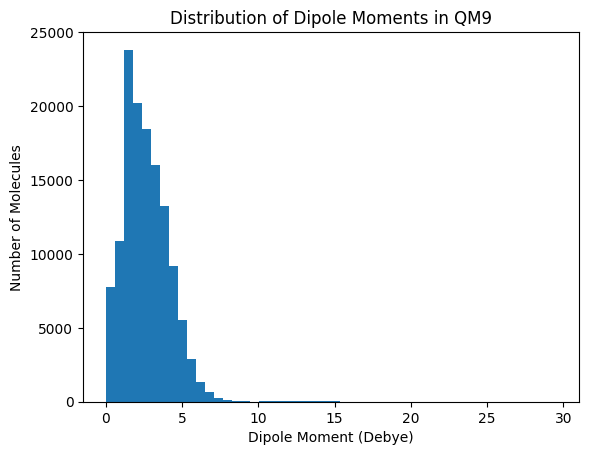

In [18]:
#plot histogram of dipole moments
import matplotlib.pyplot as plt
plt.hist(y, bins=50)
plt.xlabel('Dipole Moment (Debye)')
plt.ylabel('Number of Molecules')
plt.title('Distribution of Dipole Moments in QM9')
plt.show()
